In [1]:
import geopandas
import geopandas as gpd
import pandas as pd
from osgeo import ogr,gdal
import numpy 
from shapely.wkb import loads
from shapely.geometry import Point
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import openpyxl
import itertools
import networkx as nx
from simplify import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
gdal.SetConfigOption("OSM_CONFIG_FILE", "osmconf.ini")

# Define a helper function to generate pairs of consecutive elements in a list
def pairwise(iterable):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)
    
# Define a helper function to generate permutations
def permutations(iterable, r=None):
   # permutations('ABCD', 2) --> AB AC AD BA BC BD CA CB CD DA DB DC
    # permutations(range(3)) --> 012 021 102 120 201 210
    pool = tuple(iterable)
    n = len(pool)
    r = n if r is None else r
    if r > n:
        return
    indices = list(range(n))
    cycles = list(range(n, n-r, -1))
    yield tuple(pool[i] for i in indices[:r])
    while n:
        for i in reversed(range(r)):
            cycles[i] -= 1
            if cycles[i] == 0:
                indices[i:] = indices[i+1:] + indices[i:i+1]
                cycles[i] = n - i
            else:
                j = cycles[i]
                indices[i], indices[-j] = indices[-j], indices[i]
                yield tuple(pool[i] for i in indices[:r])
                break
        else:
            return 
        
# Retrive data from OSM and get the geographic data of tram
def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 

def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id']
    
    
    for a in keyCol: cl.append(a)
    if data is not None:
        for feature in sql_lyr:
            try:
                if feature.GetField(keyCol[0]) is not None:
                    shapely_geo = shapely.from_wkt(feature.geometry().ExportToWkt())
                    if shapely_geo is None:
                        continue
                    # field will become a row in the dataframe.
                    field = []
                    for i in cl: field.append(feature.GetField(i))
                    field.append(shapely_geo)   
                    features.append(field)
            except:
                print("WARNING: skipped OSM feature")
      
    cl.append('geometry')                   
    if len(features) > 0:
        return geopandas.GeoDataFrame(features,columns=cl) #,crs={'init': 'epsg:4326'}
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return geopandas.GeoDataFrame(columns=['osm_id','geometry']) #,crs={'init': 'epsg:4326'}    
    
def road(osm_path):
    
    return retrieve(osm_path,'lines',['highway'])  # ,**{'highway':["='tertiary'"]}


def public_stations(osm_path):
    
    return (retrieve(osm_path,'points',['public_transport', 'tram', 'subway', 'bus', 'name']))

def stations_bus(osm_path):
    df_publich__transport_stations = public_stations(osm_path)
    
    stations_bus = df_publich__transport_stations.loc[df_publich__transport_stations.bus == 'yes']
    stations_bus = stations_bus.loc[stations_bus.public_transport == 'stop_position']
    
    stations_bus['geo_x'] = stations_bus.geometry.x
    stations_bus['geo_y'] = stations_bus.geometry.y
    
    return stations_bus

def add_stations(net,station_file):
    
    station_geometries = pd.DataFrame(station_file.geometry)
    
    net.nodes = pd.concat([net.nodes,station_geometries]).reset_index(drop=True)
                           
    return net

# Pre-processing the geographic data of the subway network to obtain 'edges' and 'nodes'
def prepare_network(subway,station_file):
    """
    Prepare a subway network represented as a GeoDataFrame of LineString objects for routing.

    Args:
    - subway: a GeoDataFrame representing the subway network, with 'geometry' column containing LineString objects
    
    Returns:
    - a tuple of two DataFrames representing the edges and nodes of the prepared network

    Example:
    >>> import geopandas
    >>> subway = geopandas.read_file('subway.shp')
    >>> edges, nodes = prepare_network(subway)

    Note: This function requires the shapely, NetworkX, and Pandas libraries to be installed.
    """

    # Build a Network object from the subway edges
    net = Network(edges=subway)

    # Add endpoints to the network where edges don't intersect
    net = add_endpoints(net)
    
    # Add endpoints to the network where edges don't intersect
    net = add_stations(net,station_file)
        
    # Split edges at new endpoints
    net = split_edges_at_nodes(net)

    # Add new endpoints where edges were split
    net = add_endpoints(net)

    # Assign unique IDs to nodes and edges
    net = add_ids(net)

    # Add missing topology information to the network's edges
    net = add_topology(net)    

    # Calculate the degree of each node in the network
    net.nodes['degree'] = calculate_degree(net)

    # Merge edges with a degree of 2
    #net = merge_edges(net)

    # Drop duplicate edges
    net.edges = drop_duplicate_geometries(net.edges, keep='first') 

    # Reset node and edge IDs after fixing topology and merging edges
    net = reset_ids(net) 

    # Add edge distances
    net = add_distances(net)

    # Merge any MultiLineString edges
    net = merge_multilinestrings(net)

    # Add travel time for each edge based on distance and average speed
    net = add_travel_time(net)
    
    # Return the edges and nodes of the prepared network
    return net.edges, net.nodes

def expand_edges(edges):
    """
    Expand a DataFrame of edges into a format that can be used with network analysis algorithms.

    Args:
    - edges: a DataFrame containing edges with columns 'from_id', 'to_id', and 'distance'

    Returns:
    - a DataFrame containing expanded edges with columns 'from_id', 'to_id', 'distance', 'weights', 'to_from', and 'from_to'

    Example:
    >>> edges = pd.DataFrame({'from_id': [0, 0, 1], 'to_id': [1, 2, 2], 'distance': [1.5, 3.2, 2.8]})
    >>> expand_edges(edges)
      from_id  to_id  distance  weights  to_from  from_to
    0       0      1       1.5        1  (0, 1)  (1, 0)
    1       0      2       3.2        3  (0, 2)  (2, 0)
    2       1      2       2.8        2  (1, 2)  (2, 1)

    Notes:
    - The 'weights' column is created by rounding the 'distance' column to the nearest integer.
    - The 'to_from' and 'from_to' columns are created to facilitate conversion between edge formats.
    """
    # Round the distance to the nearest integer and store it in a new column 'weights'
    edges['weights'] = edges['distance'].astype(int)

    # Create 'to_from' and 'from_to' columns to facilitate conversion between edge formats
    edges['to_from'] = list(zip(edges.from_id, edges.to_id))
    edges['from_to'] = list(zip(edges.to_id, edges.from_id))

    # Return the expanded edges DataFrame
    return edges

In [105]:
def routes(osm_path):
    """
    Extracts route data from an OpenStreetMap file at the specified file path and returns it as a Pandas DataFrame.

    Parameters:
    osm_path (str): The file path of the OpenStreetMap file.

    Returns:
    Pandas DataFrame: A DataFrame containing route data extracted from the OpenStreetMap file.
    """

    # Call the 'retrieve' function to extract route data from the OpenStreetMap file
    # The 'retrieve' function takes three arguments:
    # - The file path of the OpenStreetMap file
    # - A list of geometry types to extract (in this case, only multilinestrings)
    # - A list of tag keys to extract (in this case, 'route', 'name', and 'ref')
    route_data = retrieve(osm_path, 'multilinestrings', ['route', 'to', 'name', 'ref', 'network', 'service'])#,'from'])

    # Return the extracted route data as a Pandas DataFrame
    return route_data

def bus_routes(osm_path):
    df_routes = routes(osm_path)
    bus_routes = pd.DataFrame(df_routes.loc[df_routes.route == 'bus'])
    return bus_routes

def sorted_routes(routes_file):     
    routes_file['ref'] = routes_file['ref'].astype(int)
    routes_file = routes_file.sort_values('ref')
    routes_file = routes_file.reset_index(drop=True)
    return routes_file

def check_to_column(sorted_routes_file, all_stations_file):
    
    def check_similarity(row):
        if row['to'] in all_stations_file['name'].values:
            return 'no need to revise'
        else:
            return row
    result = pd.DataFrame(sorted_routes_file.apply(check_similarity, axis=1))
    return result

def start_station_dict(routes_file):
    start_station_name_dict = {}
    for index, row in routes_file.iterrows():
        key = row['name']
        value = row['to']
        start_station_name_dict[key] = value
    return start_station_name_dict

def line_dict(routes_file):
    line_num_dict = {}
    for index, row in routes_file.iterrows():
        key = row['name']
        line_num_dict[key] = index
    return line_num_dict

def all_station_list(all_stations_file):
    all_stations_file= gpd.GeoDataFrame(all_stations_file.copy())
    all_stations_name = all_stations_file[['name', 'geometry', 'geo_x', 'geo_y']].reset_index(drop=True)
    return all_stations_name
    
# Sorting the stations on each route
def order_route(first_stop, unordered_route):
    new_order = []
    remaining_route = unordered_route.drop(unordered_route[unordered_route.name == first_stop.name.values[0]].index).reset_index(drop=True)
    tree = shapely.STRtree(remaining_route.geometry)
    new_order.append(first_stop)
    for iter_ in range(len(remaining_route)):
        try:
            if iter_ == 0:
                nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(first_stop.geometry)[0]]).T
                new_order.append(nearest_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.STRtree(remaining_route.geometry)
            elif iter_ == 1:
                second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
                new_order.append(second_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.STRtree(remaining_route.geometry)
            else:
                second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T
                new_order.append(second_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.STRtree(remaining_route.geometry)
        except TypeError:
            pass  # pass 'NoneType' object is not subscriptable Error
    return pd.concat(new_order).reset_index(drop=True)

def order_stations_inline(tram_line_dict,all_tram_stations_name,tram_routes,tram_start_station_name_dict):
    
    tram_stations_dict = tram_line_dict.copy()

    for key,value in tram_stations_dict.items():
        value1 = value
        value2 = all_tram_stations_name.loc[all_tram_stations_name.within(tram_routes.iloc[value1].geometry.buffer(0.00000001))]
        value2['id'] = value2.reset_index().index
        tram_stations_dict[key] = value2[['id', 'name', 'geometry', 'geo_x', 'geo_y']].reset_index(drop=True)
    
    tram_stations_inorder_dict = tram_line_dict.copy()
    tram_order_route_dict = tram_line_dict.copy()

    for line in tram_stations_inorder_dict.keys():
        tram_stations_inorder = tram_stations_dict[line]
        for i in range(len(tram_stations_inorder)):
            if tram_stations_inorder.iloc[i]['name'] == tram_start_station_name_dict[line]:
                tram_stations_inorder_dict[line] = pd.DataFrame(tram_stations_inorder.iloc[i]).T
                print(tram_stations_inorder_dict[line])
        tram_order_route_dict[line] = order_route(tram_stations_inorder_dict[line], tram_stations_dict[line])

    return tram_order_route_dict

def s_e_coordinates_pairs(s_e_coordinates):
    """
    Given a Pandas DataFrame `s_e_coordinates` with columns `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, 
    and `e_coordinates_y`, returns a new DataFrame with columns `s_coordinates` and `e_coordinates`.
    
    `s_coordinates` and `e_coordinates` are each a tuple of the form `(x, y)`, where `x` is the value in the 
    `s_coordinates_x` or `e_coordinates_x` column, and `y` is the value in the `s_coordinates_y` or `e_coordinates_y` 
    column.
    
    Parameters
    ----------
    s_e_coordinates : pandas.DataFrame
        A DataFrame with columns `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, and `e_coordinates_y`.
    
    Returns
    -------
    pandas.DataFrame
        A new DataFrame with columns `s_coordinates` and `e_coordinates`.
    """
    
    # Create an empty DataFrame to hold the new columns
    s_e_coordinates_pairs = pd.DataFrame()
    
    # Create the `s_coordinates` column by zipping the `s_coordinates_x` and `s_coordinates_y` columns
    s_e_coordinates_pairs['s_coordinates'] = list(zip(s_e_coordinates.s_coordinates_x, s_e_coordinates.s_coordinates_y))
    
    # Create the `e_coordinates` column by zipping the `e_coordinates_x` and `e_coordinates_y` columns
    s_e_coordinates_pairs['e_coordinates'] = list(zip(s_e_coordinates.e_coordinates_x, s_e_coordinates.e_coordinates_y))
    
    # Return the new DataFrame
    return s_e_coordinates_pairs


# Define nearest nodes with real_world coordinates of start and end points, obtain the nearest id pairs of nodes 
def find_nearest_node(coordinate, nodes):
    """
    Find the nearest node to a given coordinate or geometry in a GeoDataFrame of nodes.

    Args:
    - coordinate: a tuple of longitude and latitude (in decimal degrees) or a shapely geometry object representing the location to search from
    - nodes: a GeoDataFrame containing nodes with a 'geometry' column representing their coordinates as shapely Point objects
    
    Returns:
    - the id value of the nearest node to the input coordinate or geometry

    Example:
    >>> import geopandas
    >>> from shapely.geometry import Point
    >>> from shapely import Geometry
    >>> nodes = geopandas.read_file('nodes.shp')
    >>> coordinate = (-122.3, 47.6)
    >>> find_nearest_node(coordinate, nodes)
    1234

    Note: This function requires the shapely and STRtree libraries to be installed.
    """
    # Build an STRtree index of the nodes' geometries for efficient nearest-neighbor search
    node_tree = shapely.STRtree(nodes.geometry)
   
    # Find the nearest node to the input coordinate or geometry using the STRtree index
    if isinstance(coordinate, tuple):
        find_nearest = node_tree.nearest(shapely.points(coordinate))
    elif isinstance(coordinate, shapely.lib.Geometry):
        find_nearest = node_tree.nearest(coordinate)
    
    # Return the id value of the nearest node from the nodes GeoDataFrame
    # print(nodes.iloc[find_nearest[1]]['id'])
    return int(nodes.iloc[find_nearest]['id'])

def id_pairs(coordinates_pairs, nodes):
    """
    Map the start and end coordinates to the nearest nodes in a transportation network.

    Args:
    - coordinates_pairs: a pandas DataFrame containing start and end coordinates in the network, with columns 's_coordinates', 'e_coordinates'
    - nodes: a GeoDataFrame containing nodes in the network, with a 'geometry' column representing their coordinates as shapely Point objects

    Returns:
    - a pandas DataFrame containing the nearest node IDs for each start and end coordinate pair, with columns 's_id', 'e_id'

    """
    # Initialize an empty DataFrame to store the start and end node IDs
    id_pairs = pd.DataFrame(columns=['s_id','e_id'])
    pairs_num = coordinates_pairs.shape[0]
    
    # For each start and end coordinate pair, find the nearest node in the network and store the node IDs in the DataFrame
    for i in range(pairs_num):
        s_coordinate = shapely.points(coordinates_pairs.s_coordinates[i])
        s_id = find_nearest_node(s_coordinate, nodes)
        e_coordinate = shapely.points(coordinates_pairs.e_coordinates[i])
        e_id = find_nearest_node(e_coordinate, nodes)
        id_pairs.loc[i] = [s_id,e_id]
        
    return id_pairs

def id_pairs_inline(tram_line_dict,tram_order_route_dict):
    tram_order_coordinates = tram_order_route_dict.copy()
    tram_order_coordinates = {key: value[['name', 'geo_x', 'geo_y']] for key, value in tram_order_coordinates.items()}

    # am_tram_order_coordinates

    new_dict = {}

    for key, value in tram_order_coordinates.items():
        shifted_value = pd.concat([value, value.shift(-1)], axis=1)
        shifted_value.columns = [f'col{i+1}' for i in range(len(value.columns))] + [f'col{i+4}' for i in range(len(value.columns))]
        new_dict[key] = shifted_value.dropna().reset_index(drop=True)
    
    tram_order_coordinates = {key: value[['col1', 'col4', 'col2', 'col3', 'col5', 'col6']] for key, value in new_dict.items()}

    for key, value in tram_order_coordinates.items():
        value.rename(columns={'col1': 's_name', 'col4': 'e_name','col2': 's_coordinates_x', 'col3': 's_coordinates_y', 'col5': 'e_coordinates_x', 'col6': 'e_coordinates_y'}, inplace=True)
    
    tram_order_coordinates_pairs = tram_order_coordinates.copy()
    tram_order_id_pairs = tram_order_coordinates.copy()

    for line in tram_order_coordinates.keys():
        tram_order_coordinates_pairs[line] = s_e_coordinates_pairs(tram_order_coordinates[line])
        tram_order_id_pairs[line] = id_pairs(tram_order_coordinates_pairs[line],nodes)
    
    return(tram_order_id_pairs)

## Step1: retrive all tram stations, edges and nodes from OSM map

In [4]:
#osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.bbbike.pbf"

In [5]:
city_bus_stations = stations_bus(osm_path)

In [6]:
city_bus_stations

,osm_id,public_transport,tram,subway,bus,name,geometry,geo_x,geo_y
1,45979527,stop_position,None,None,yes,Westwijk,POINT (4.83009 52.27420),4.830088,52.274203
2,45979744,stop_position,None,None,yes,Sluis,POINT (5.02391 52.27442),5.023914,52.274421
3,45980296,stop_position,None,None,yes,Sluis,POINT (5.02437 52.27450),5.024366,52.274499
4,45984876,stop_position,None,None,yes,"Aalsmeer, Nieuw Oosteinde",POINT (4.80938 52.27574),4.809385,52.275743
6,45991272,stop_position,None,None,yes,"Aalsmeer, Machineweg",POINT (4.78909 52.27753),4.789086,52.277532
...,...,...,...,...,...,...,...,...,...
3664,10573390383,stop_position,None,None,yes,Archangelkade,POINT (4.87193 52.39554),4.871933,52.395537
3666,10573464339,stop_position,None,None,yes,Archangelkade,POINT (4.87199 52.39539),4.871988,52.395390
3669,10582633274,stop_position,None,None,yes,Olof Palmeplein,POINT (4.94008 52.39669),4.940081,52.396687
3671,10661819286,stop_position,None,None,yes,Wolbrantskerkweg,POINT (4.79742 52.35691),4.797423,52.356906


In [7]:
city_bus_stations.to_excel('./city_bus_stations.xlsx',header = True, index = False)  

In [8]:
replacement_dict = {
    'Amsterdam,': '',
}

city_bus_stations['name'] = city_bus_stations['name'].replace(replacement_dict, regex=True).str.strip()

<Axes: >

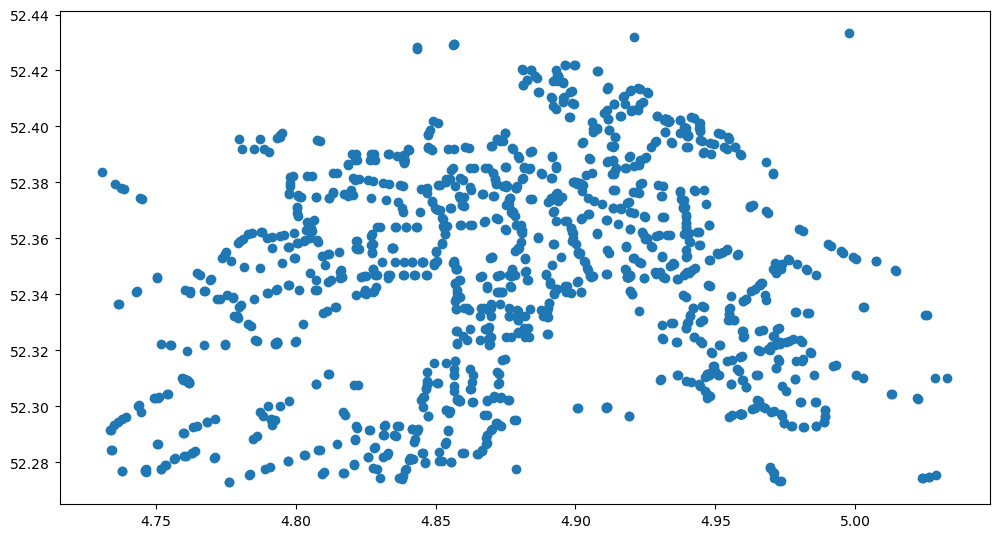

In [9]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(city_bus_stations.copy()).plot(ax=ax,zorder=0)

In [10]:
city_bus = road(osm_path)

<Axes: >

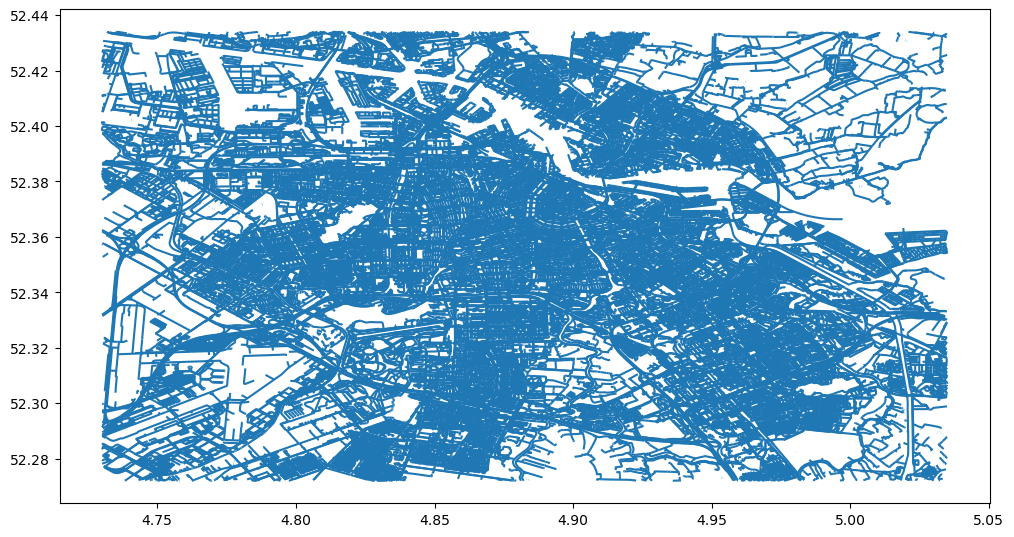

In [11]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(city_bus.copy()).plot(ax=ax,zorder=0)

In [12]:
edges,nodes = prepare_network(city_bus,city_bus_stations)

topology: 100%|██████████████████████████████████████████████████████████████| 192772/192772 [00:21<00:00, 8806.68it/s]


In [13]:
edges = expand_edges(edges)

## Test 2-retrive routes, intersect the result with nodes to get stations on each route, then order the stations on each route and calculate the id pairs until shortest path

In [88]:
city_bus_routes = bus_routes(osm_path)
city_bus_routes = city_bus_routes.loc[city_bus_routes.network == 'Stadsvervoer Amsterdam']
city_bus_routes = city_bus_routes.loc[city_bus_routes.service != 'night']
city_bus_routes

,osm_id,route,to,name,ref,network,service,geometry
27,73789,bus,Amsterdam Muiderpoortstation,Bus 40: Amsterdam Amstelstation => Amsterdam M...,40,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.91869 52.34617, 4.91868 52..."
32,146350,bus,"Schiphol, Airport/Plaza",Bus 365: Leiden Centraal Station => Schiphol A...,365,Zuid-Holland Noord,None,"MULTILINESTRING ((4.76218 52.30830, 4.76200 52..."
38,156123,bus,Marken Minneweg,Bus 315: Amsterdam Station Noord => Marken Min...,315,Waterland,None,"MULTILINESTRING ((4.93321 52.40187, 4.93311 52..."
43,161790,bus,"Nieuw Vennep, P+R Getsewoud Zuid",Bus 397: Amsterdam Busstation Elandsgracht → N...,397,Amstelland-Meerlanden,None,"MULTILINESTRING ((4.87678 52.36968, 4.87687 52..."
74,169215,bus,"Haarlem, Station",Bus 300: Amsterdam Bijlmer ArenA → Haarlem Sta...,300,Amstelland-Meerlanden,None,"MULTILINESTRING ((4.94705 52.31143, 4.94711 52..."
...,...,...,...,...,...,...,...,...
1299,13630218,bus,"Amsterdam, Station Noord",Bus 292: Zaandam De Vlinder => Amsterdam Stati...,292,Zaanstreek,None,"MULTILINESTRING ((4.85659 52.42963, 4.85664 52..."
1300,13631642,bus,"Assendelft, Festina Lente",Bus 63: Zaandam Station => Assendelft Festina ...,63,Zaanstreek,None,"MULTILINESTRING ((4.81470 52.43396, 4.81392 52..."
1301,13633193,bus,"Zaandam, Station",Bus 63: Assendelft Festina Lente => Zaandam St...,63,Zaanstreek,None,"MULTILINESTRING ((4.81505 52.43381, 4.81512 52..."
1323,14979096,bus,"Amsterdam, Station Bijlmer ArenA",Bus 330: Almere Station Buiten => Amsterdam St...,330,Busvervoer Almere,None,"MULTILINESTRING ((5.03419 52.33149, 5.03355 52..."


In [89]:
# city_bus_routes = city_bus_routes.loc[city_bus_routes.network == 'Stadsvervoer Amsterdam']

In [91]:
# city_bus_routes = city_bus_routes.loc[city_bus_routes.service != 'night']

In [93]:
city_bus_routes = sorted_routes(city_bus_routes)
city_bus_routes

,osm_id,route,to,name,ref,network,service,geometry
0,4514662,bus,"Amsterdam, Station Sloterdijk",Bus 15: Amsterdam Station Zuid => Amsterdam St...,15,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87260 52.34084, 4.87241 52..."
1,364648,bus,"Amsterdam, Station Zuid",Bus 15: Amsterdam Station Sloterdijk => Amster...,15,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83881 52.38771, 4.83870 52..."
2,365436,bus,"Amsterdam, Louweshoek",Bus 18: Amsterdam Centraal Station => Amsterda...,18,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.90027 52.37972, 4.89945 52..."
3,4516350,bus,"Amsterdam, Centraal Station",Bus 18: Amsterdam Slotervaart => Amsterdam Cen...,18,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.82319 52.34629, 4.82319 52..."
4,4517357,bus,"Amsterdam, Centraal Station",Bus 21: Amsterdam Geuzenveld => Amsterdam Cent...,21,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.80073 52.37546, 4.80070 52..."
...,...,...,...,...,...,...,...,...
58,6900422,bus,Amsterdam Gelderlandplein NO,Bus 461: Amsterdam Gustav Mahlerplein => Amste...,461,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87311 52.33665, 4.87324 52..."
59,6900421,bus,"Amsterdam, Bolestein",Bus 463: Amsterdam Gelderlandplein Oost => Ams...,463,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87942 52.33081, 4.87942 52..."
60,6900419,bus,"Amsterdam, Gelderlandplein Noord",Bus 463: Amsterdam Bolestein => Amsterdam Geld...,463,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.85967 52.32498, 4.85967 52..."
61,11730318,bus,"Amsterdam, De Boelelaan",Bus 464: Amsterdam De Boelelaan/De Klencke => ...,464,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.88732 52.33438, 4.88756 52..."


In [97]:
replacement_dict1 = {
    ',': '',
    'Amsterdam': '',
    'Osdorp De Aker': 'Matterhorn',
    'De Boelelaan': 'De Boelelaan / VU',
    'Weesp Station': 'Weesperplein'  
}
replacement_dict2 = {
    'Schiphol Zuid Toekanweg': 'Schiphol Zuid, Toekanweg',
    'Schiphol Airport/Plaza': 'Schiphol, Airport',
}
city_bus_routes['to'] = city_bus_routes['to'].replace(replacement_dict1, regex=True).str.strip()
city_bus_routes['to'] = city_bus_routes['to'].replace(replacement_dict2, regex=True).str.strip()
city_bus_routes = city_bus_routes.reset_index(drop=True)
city_bus_routes

,osm_id,route,to,name,ref,network,service,geometry
0,4514662,bus,Station Sloterdijk,Bus 15: Amsterdam Station Zuid => Amsterdam St...,15,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87260 52.34084, 4.87241 52..."
1,364648,bus,Station Zuid,Bus 15: Amsterdam Station Sloterdijk => Amster...,15,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83881 52.38771, 4.83870 52..."
2,365436,bus,Louweshoek,Bus 18: Amsterdam Centraal Station => Amsterda...,18,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.90027 52.37972, 4.89945 52..."
3,4516350,bus,Centraal Station,Bus 18: Amsterdam Slotervaart => Amsterdam Cen...,18,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.82319 52.34629, 4.82319 52..."
4,4517357,bus,Centraal Station,Bus 21: Amsterdam Geuzenveld => Amsterdam Cent...,21,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.80073 52.37546, 4.80070 52..."
...,...,...,...,...,...,...,...,...
58,6900422,bus,Gelderlandplein NO,Bus 461: Amsterdam Gustav Mahlerplein => Amste...,461,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87311 52.33665, 4.87324 52..."
59,6900421,bus,Bolestein,Bus 463: Amsterdam Gelderlandplein Oost => Ams...,463,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87942 52.33081, 4.87942 52..."
60,6900419,bus,Gelderlandplein Noord,Bus 463: Amsterdam Bolestein => Amsterdam Geld...,463,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.85967 52.32498, 4.85967 52..."
61,11730318,bus,De Boelelaan / VU,Bus 464: Amsterdam De Boelelaan/De Klencke => ...,464,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.88732 52.33438, 4.88756 52..."


In [98]:
need_revised_row = check_to_column(city_bus_routes, city_bus_stations)

In [99]:
need_revised_row

,0
0,no need to revise
1,no need to revise
2,no need to revise
3,no need to revise
4,no need to revise
...,...
58,no need to revise
59,no need to revise
60,no need to revise
61,no need to revise


In [100]:
need_revised_row.to_excel('./need_revised_row.xlsx',header = True, index = False)  

In [101]:
citybus_start_station_name_dict = start_station_dict(city_bus_routes)
citybus_start_station_name_dict

{'Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk': 'Station Sloterdijk',
 'Bus 15: Amsterdam Station Sloterdijk => Amsterdam Station Zuid': 'Station Zuid',
 'Bus 18: Amsterdam Centraal Station => Amsterdam Slotervaart': 'Louweshoek',
 'Bus 18: Amsterdam Slotervaart => Amsterdam Centraal Station': 'Centraal Station',
 'Bus 21: Amsterdam Geuzenveld => Amsterdam Centraal Station': 'Centraal Station',
 'Bus 21: Amsterdam Centraal Station => Amsterdam Geuzenveld': 'Nolensstraat',
 'Bus 22: Amsterdam Muiderpoortstation => Amsterdam Station Sloterdijk': 'Station Sloterdijk',
 'Bus 22: Amsterdam Station Sloterdijk => Amsterdam Muiderpoortstation': 'Muiderpoortstation',
 'Bus 34: Amsterdam Olof Palmeplein => Amsterdam Noorderpark': 'Noorderpark',
 'Bus 34: Amsterdam Noorderpark => Amsterdam Olof Palmeplein': 'Olof Palmeplein',
 'Bus 35: Amsterdam Molenwijk => Amsterdam Olof Palmeplein': 'Olof Palmeplein',
 'Bus 35: Amsterdam Olof Palmeplein => Amsterdam Molenwijk': 'Molenwijk',


In [102]:
citybus_line_dict = line_dict(city_bus_routes)

In [103]:
citybus_stations_name = all_station_list(city_bus_stations)

In [106]:
citybus_order_route_dict = order_stations_inline(citybus_line_dict,citybus_stations_name,city_bus_routes,citybus_start_station_name_dict)

  id                name                      geometry     geo_x      geo_y
4  4  Station Sloterdijk  POINT (4.8388077 52.3877091)  4.838808  52.387709
  id          name                      geometry     geo_x      geo_y
0  0  Station Zuid  POINT (4.8736017 52.3408906)  4.873602  52.340891
  id          name                     geometry     geo_x      geo_y
7  7  Station Zuid  POINT (4.873716 52.3407537)  4.873716  52.340754
  id          name                      geometry     geo_x      geo_y
8  8  Station Zuid  POINT (4.8725964 52.3408355)  4.872596  52.340835
  id          name                      geometry     geo_x      geo_y
9  9  Station Zuid  POINT (4.8727824 52.3407386)  4.872782  52.340739
  id        name                      geometry    geo_x      geo_y
0  0  Louweshoek  POINT (4.8231898 52.3462931)  4.82319  52.346293
  id              name                     geometry     geo_x      geo_y
4  4  Centraal Station  POINT (4.901977 52.3790911)  4.901977  52.379091
  id      

AttributeError: 'int' object has no attribute 'name'

In [ ]:
am_tram_start_station_name_dict = start_station_dict(am_tram_routes)
# am_tram_start_station_name_dict

In [ ]:
am_tram_line_dict = line_dict(am_tram_routes)
# am_tram_line_dict

In [ ]:
am_all_tram_stations_name = all_station_list(am_all_tram_stations)
# am_all_tram_stations_name

In [ ]:
am_tram_order_route_dict = order_stations_inline(am_tram_line_dict,am_all_tram_stations_name,am_tram_routes,am_tram_start_station_name_dict)
# am_tram_order_route_dict

In [ ]:
am_tram_order_id_pairs = id_pairs_inline(am_tram_line_dict,am_tram_order_route_dict)
# am_tram_order_id_pairs

In [ ]:
G = create_ground_graph(edges, nodes)

In [ ]:
am_tram_shortest_path_pairs = am_tram_order_id_pairs.copy()
duplicate_row_count = am_tram_order_id_pairs.copy()
am_tram_shortest_path_edges = am_tram_order_id_pairs.copy()
am_tram_edges = am_tram_order_id_pairs.copy()

for line in am_tram_order_id_pairs.keys():
    am_tram_shortest_path_pairs[line] = all_shortest_paths(am_tram_order_id_pairs[line],edges)
    duplicate_row_count[line], am_tram_shortest_path_edges[line], am_tram_edges[line] = edges_with_count_weight(am_tram_shortest_path_pairs[line],edges)

In [ ]:
plot_routes_even(am_tram_routes,edges,am_tram_shortest_path_edges)

In [ ]:
plot_routes_odd(am_tram_routes,edges,am_tram_shortest_path_edges)

In [ ]:
am_tram_shortest_edges_list = list(am_tram_shortest_path_edges.items())

In [ ]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))

for i, ax in enumerate(axes.flat):
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='black')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='purple')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='red')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='brown')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='black')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='green')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='blue')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='orange')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='purple')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='red')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='brown')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()
    

In [ ]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))

for i, ax in enumerate(axes.flat):
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='black')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='purple')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='red')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='brown')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='black')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='green')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='blue')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='orange')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='purple')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='red')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='brown')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()
    

Tram4 on OSM is different from it on GVB website, this research is based on OSM.

In [ ]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))

# gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
# gpd.GeoDataFrame(am_tram_shortest_path_edges['am_tram_line4_0'].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges['am_tram_line4_0'].count_weight)*2,color='orange')
# ax.set_title('Route 4')